In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open

In [8]:
L = 25
sample_length = 1000
C = 30
seed = 8
snu = 0.1
mu = -3.5

save_path = f'saved/synthetic_data/simple_synthetic_{L}_{sample_length}_{C}_{mu}_{snu}_{seed}'

data_load = pickle_open(save_path)

pp_params = data_load['observed']['pp_params']
lfp = data_load['observed']['lfp']
spikes = data_load['observed']['spikes']

xns = data_load['latent']['xns']
xys = data_load['latent']['xys']

xnfs = data_load['latent']['xnfs']
xyfs = data_load['latent']['xyfs']
Gamma = data_load['latent']['Gamma']
true_coh = data_load['meta']['coh_true']
coh1 = data_load['meta']['coh_direct_est']

freqs = data_load['meta']['freqs']

In [11]:
def plot_synthetic_data(L, sample_length, C, snu, seed, mu):
    save_path = f'saved/synthetic_data/simple_synthetic_{L}_{sample_length}_{C}_{mu}_{snu}_{seed}'

    data_load = pickle_open(save_path)

    pp_params = data_load['observed']['pp_params']
    lfp = data_load['observed']['lfp']
    spikes = data_load['observed']['spikes']

    xns = data_load['latent']['xns']
    xys = data_load['latent']['xys']

    xnfs = data_load['latent']['xnfs']
    xyfs = data_load['latent']['xyfs']
    Gamma = data_load['latent']['Gamma']
    true_coh = data_load['meta']['coh_true']
    coh1 = data_load['meta']['coh_direct_est']

    freqs = data_load['meta']['freqs']

    true_mus = pp_params['mu'] 
    true_betas = pp_params['beta']  

    xns_swap = np.swapaxes(xns, 0, 1)
    lamb_pre = true_mus[:,None,None] + true_betas[:,None,None] * xns_swap[None,:]
    lamb_swap = 1/(1 + np.exp(-lamb_pre))
    lamb_swap2 = np.swapaxes(lamb_swap, 0, 2)
    lamb = np.swapaxes(lamb_swap2, 1, 2)
    test = true_betas[:,None,None] * xns_swap[None,:]

    def get_cif(mus, betas, xns, c, l):
        lamb_pre = mus[c] + betas[c]*xns[l,:]
        return 1/(1 + np.exp(-lamb_pre))

    swap = False
    ls = [0,1,2]
    fig,ax = plt.subplots(5,1,figsize=(12,10), sharex=True)
    start = 2
    title_size = 16
    label_size = 14
    x = np.arange(0, sample_length) / 1000
    # for i in range(start,start+3):
    for i, l in enumerate(ls):
    # i = 3
        ax[3].plot(x, xys[l,:])
        ax[3].set_ylim([-.3,.3])
        ax[3].margins(0)
        ax[3].set_title(r'$x_{y,t}^{\ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[3].set_ylabel('mV', size = label_size)
        
        ax[0].plot(x, xns[l,:])
        ax[0].set_ylim([-1,1])
        ax[0].margins(0)
        ax[0].set_title(r'$x_{n,t}^{\ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[0].set_ylabel('mV', size = label_size)
        
        ax[4].plot(x, lfp[l,:])
        ax[4].margins(0)
        ax[4].set_title(r'$y_t^{\ell}$   $\ell = (1,2,3)$', size=title_size)
        ax[4].set_ylabel('mV', size = label_size)
    #     ax[3].plot(spikes[i,:,:].sum(0))
    #     ax[3].set_title(r'$\bar{n}_t^{\ell}$   $\ell = (1,2,3)$')
    #     ax[3].margins(0)
        ax[1].plot(x, lamb[l,5,:])
        ax[1].set_title(r'$\lambda_t^{c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[1].margins(0)
        ax[1].set_ylabel('Intensity', size = label_size)
    # draw_raster_single(spikes[start,:,:], trange=[0,0.5], region='CPB', override_bg_color='white',ax=ax[3])
    color = 'tab:green'
    spike_mat = spikes[ls[2],:,:]
    draw_raster_single_mod(spike_mat, trange=[0,sample_length/1000], region='CPB', color_name=color, override_bg_color=None, ax=ax[2])
    ax[2].set_title(r'$n_t^{c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
    ax[2].set_ylabel('Spikes', size = label_size)

    ax[4].set_xlabel('Time (sec)', size = label_size)
    plt.xlim([0,0.5])
    plt.tight_layout()

In [13]:
import matplotlib 
trange = [0,0.5]

def draw_raster_single_mod(spike_mat, trange=[0,0.5], region='CPB', color_name='k', override_bg_color=None, ax=None):
    contrast = 0.1
    ax = ax or plt.gca()
    contrast_scale = contrast
    origin = 'lower'

    color_rgb = matplotlib.colors.to_rgba(color_name)
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    #     color_name, [(0., 0., 0., 0.),  (0., 1., 0., 0.5)])
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        color_name, [(0., 0., 0., 0.),  color_rgb])

    # colors = get_colors()
    kwargs =  {}
    kwargs.setdefault('aspect', 'auto')
    kwargs.setdefault('cmap', cmap)
    kwargs.setdefault('interpolation', None)
    kwargs.setdefault('extent', (trange[0], trange[-1], 0., spike_mat.shape[0]))

    ymin = 0
    ymax = spike_mat.shape[0]
    ax.set_ylim([ymin, ymax])
    ax.set_ylabel('Spikes')
    ax.get_yaxis().set_ticks([])
    ax.tick_params(axis='x', which='major', labelsize=12)

    alpha = 0.2
    n_units = spike_mat.shape[0]

    # if override_bg_color:
    #     ax.axhspan(0, n_units + 1, facecolor=override_bg_color, alpha=alpha) #

    # else:
    #     ax.axhspan(0, n_units + 1, facecolor=colors[region], alpha=alpha) #

    spikeraster = ax.imshow(spike_mat, origin=origin, **kwargs)
    spikeraster.set_clim(0., np.max(spike_mat) * contrast_scale)

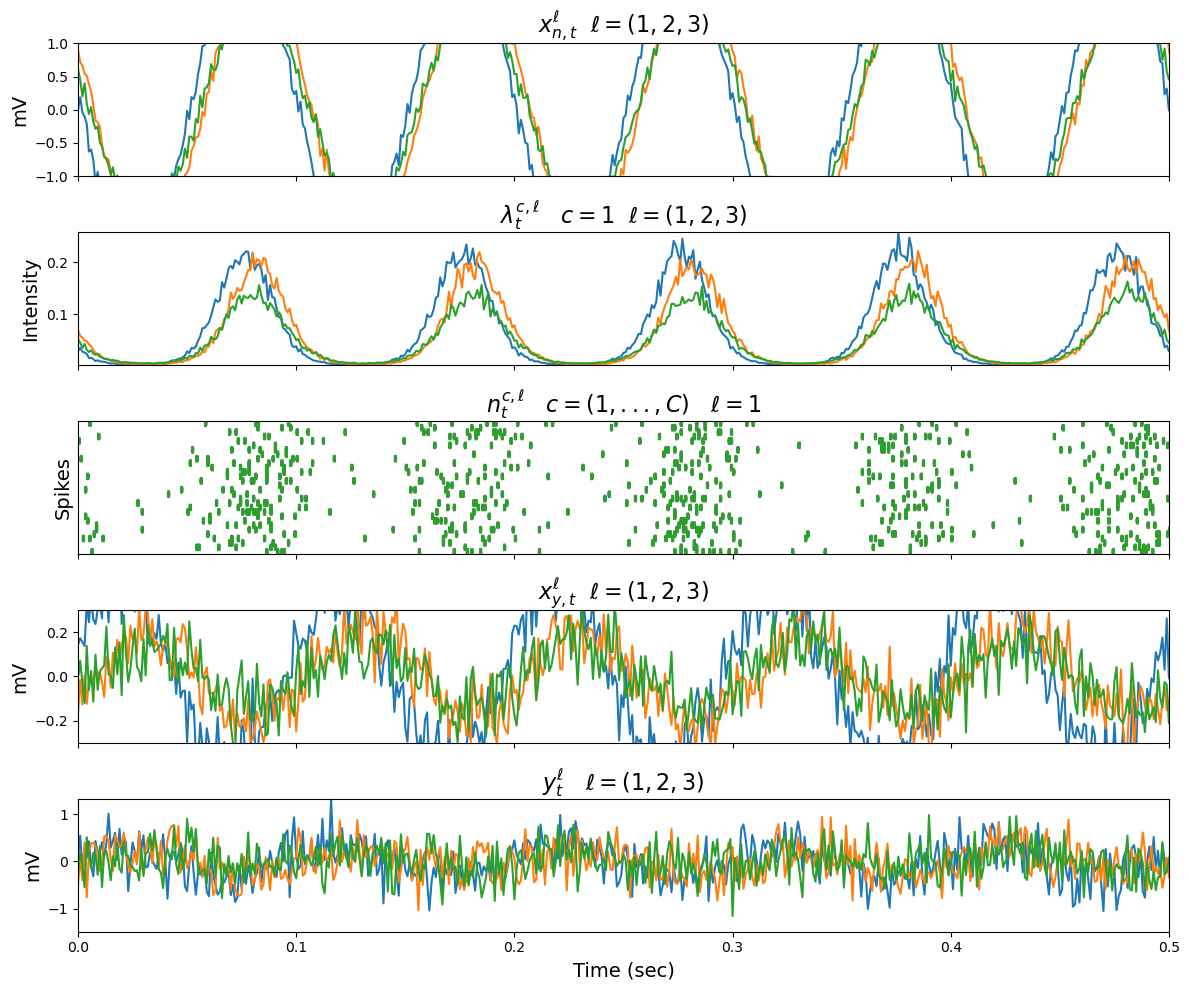

In [14]:
plot_synthetic_data(L, sample_length, C, snu, seed, mu)

In [5]:
spikes.shape

(40, 30, 2000)

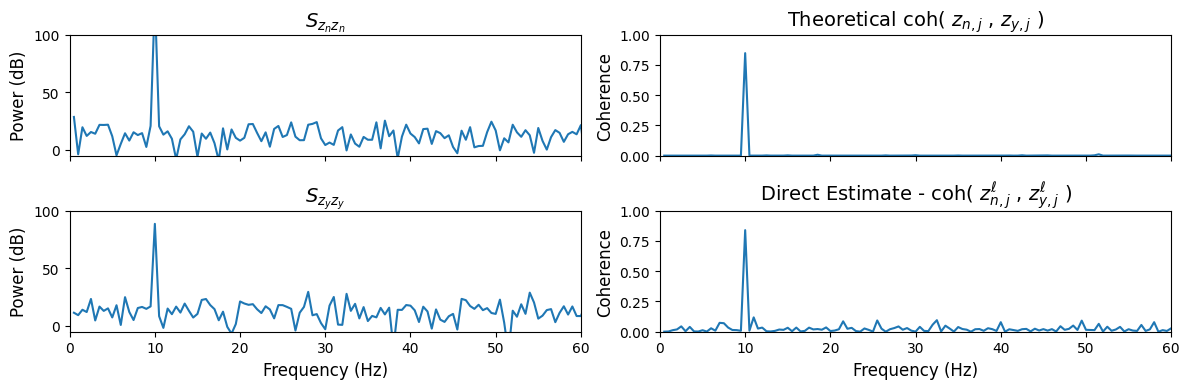

In [7]:
Sxn = (xnfs*xnfs.conj()).mean(0).real
Sxy = (xyfs*xyfs.conj()).mean(0).real
title_size = 14
label_size = 12

fig,ax = plt.subplots(2,2, figsize=(12,4), sharex=True)
lim = [0,60]
# ax[0,0].plot(freqs, 10*np.log10(Sxn))
ax[0,0].plot(freqs, 10*np.log(Gamma[:,0,0]).real)
# 10*np.log(Gamma[z_ind,0,0])
ax[0,0].set_xlim(lim)
ax[0,0].set_title(r'$S_{z_n z_n}$', size=title_size)
ax[0,0].set_ylabel('Power (dB)', size=label_size)
ax[0,0].set_ylim([-5,100])

# ax[1,0].plot(freqs, 10*np.log10(Sxy))
ax[1,0].plot(freqs, 10*np.log(Gamma[:,1,1]).real)
ax[1,0].set_xlim(lim)
ax[1,0].set_title(r'$S_{z_y z_y}$', size=title_size)
ax[1,0].set_ylim([0,50])
ax[1,0].set_ylabel('Power (dB)', size=label_size)
ax[1,0].set_xlabel('Frequency (Hz)', size=label_size)
ax[1,0].set_ylim([-5,100])

ax[1,1].plot(freqs, coh1)
ax[1,1].set_xlim(lim)
# ax[0,1].set_title(r'Direct Estimate coh est')
ax[1,1].set_title(r'Direct Estimate - coh( $z^{\ell}_{n,j}$ , $z^{\ell}_{y,j}$ )', size=title_size)
ax[1,1].set_ylim([0,1])
ax[1,1].set_ylabel('Coherence', size=label_size)
ax[1,1].set_xlabel('Frequency (Hz)', size=label_size)

ax[0,1].plot(freqs, true_coh)
ax[0,1].set_xlim(lim)
ax[0,1].set_title(r'Theoretical coh( $z_{n,j}$ , $z_{y,j}$ )', size=title_size)
ax[0,1].set_ylim([0,1])
ax[0,1].set_ylabel('Coherence', size=label_size)


plt.tight_layout()
plt.savefig('distribution.png', dpi=300)

In [8]:
true_mus = pp_params['mu'] 
true_betas = pp_params['beta']  

xns_swap = np.swapaxes(xns, 0, 1)
lamb_pre = true_mus[:,None,None] + true_betas[:,None,None] * xns_swap[None,:]
lamb_swap = 1/(1 + np.exp(-lamb_pre))
lamb_swap2 = np.swapaxes(lamb_swap, 0, 2)
lamb = np.swapaxes(lamb_swap2, 1, 2)

In [9]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':'Arial'})

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

/tmp/user/1001/ipykernel_13595/3561883722.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,5], color='white')


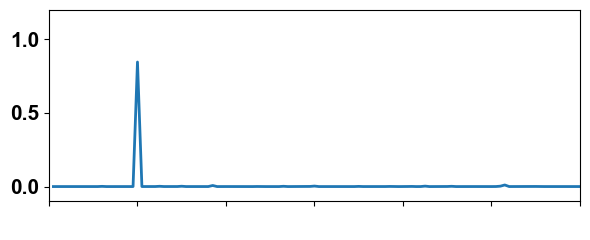

In [61]:
label_size = 12
fig, ax = plt.subplots(figsize=(6,2.5))
ax.plot(freqs, true_coh, linewidth=2 )
# ax.plot(freqs, true_coh)
# ax.plot(lb)
# ax.plot(ub)
ax.set_xlim([0,60])
ax.set_ylim([-0.1,1.2])
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15) 
ax.set_xticklabels([0,1,5], color='white')
plt.tight_layout()
plt.savefig('theoretical_coh_noxlab.pdf')



In [11]:
test = true_betas[:,None,None] * xns_swap[None,:]

In [12]:
def get_cif(mus, betas, xns, c, l):
    lamb_pre = mus[c] + betas[c]*xns[l,:]
    return 1/(1 + np.exp(-lamb_pre))

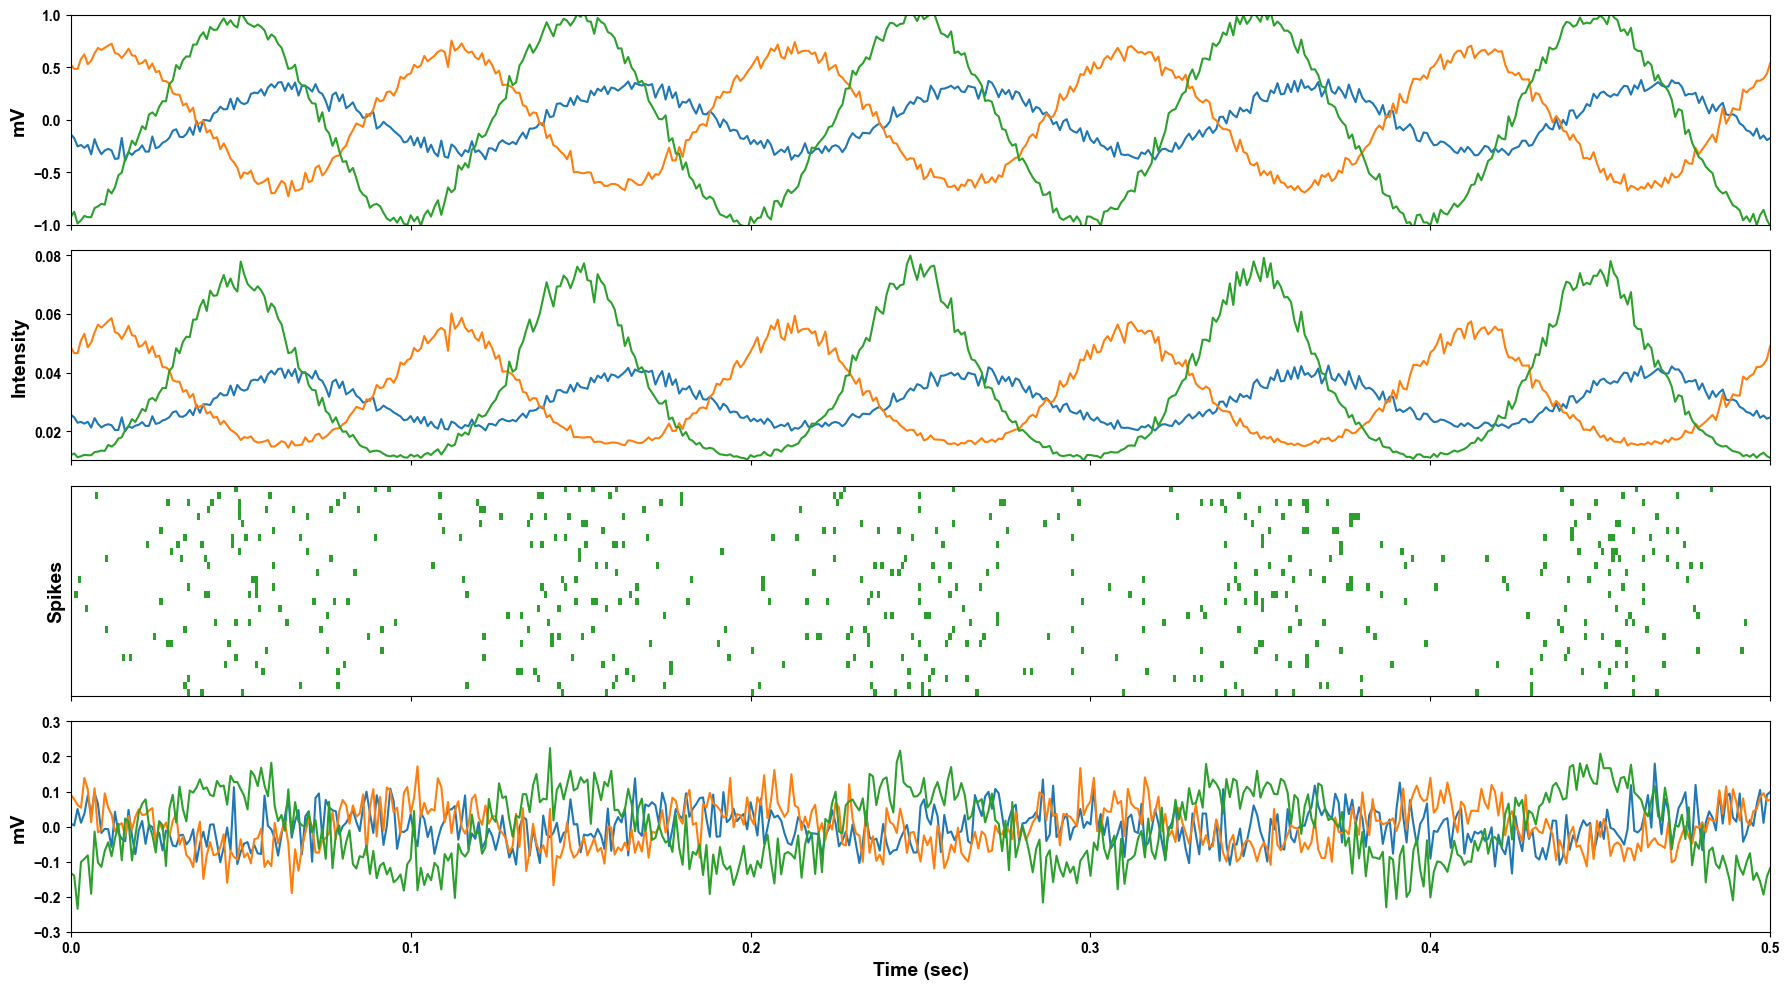

In [16]:
swap = False
ls = [1,4,9]
fig,ax = plt.subplots(4,1,figsize=(18,10), sharex=True)
start = 2
title_size = 16
label_size = 14
x = np.arange(0, sample_length) / 1000
# for i in range(start,start+3):
for i, l in enumerate(ls):
# i = 3
    ax[3].plot(x, xys[l,:])
    ax[3].set_ylim([-.3,.3])
    ax[3].margins(0)
    # ax[3].set_title(r'$x_{y,t}^{\ell}$  $\ell = (1,2,3)$', size=title_size)
    ax[3].set_ylabel('mV', size = label_size)
    
    ax[0].plot(x, xns[l,:])
    ax[0].set_ylim([-1,1])
    ax[0].margins(0)
    # ax[0].set_title(r'$x_{n,t}^{\ell}$  $\ell = (1,2,3)$', size=title_size)
    ax[0].set_ylabel('mV', size = label_size)
    
    # ax[4].plot(x, lfp[l,:])
    # ax[4].margins(0)
    # ax[4].set_title(r'$y_t^{\ell}$   $\ell = (1,2,3)$', size=title_size)
    # ax[4].set_ylabel('mV', size = label_size)
#     ax[3].plot(spikes[i,:,:].sum(0))
#     ax[3].set_title(r'$\bar{n}_t^{\ell}$   $\ell = (1,2,3)$')
#     ax[3].margins(0)
    ax[1].plot(x, lamb[l,5,:])
    # ax[1].set_title(r'$\lambda_t^{c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)
# draw_raster_single(spikes[start,:,:], trange=[0,0.5], region='CPB', override_bg_color='white',ax=ax[3])
color = 'tab:green'
spike_mat = spikes[ls[2],:,:]
draw_raster_single_mod(spike_mat, trange=[0,sample_length/1000], region='CPB', color_name=color, override_bg_color=None, ax=ax[2])
# ax[2].set_title(r'$n_t^{c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
ax[2].set_ylabel('Spikes', size = label_size)

ax[3].set_xlabel('Time (sec)', size = label_size)
plt.xlim([0,0.5])
plt.tight_layout()
if swap:
    plt.savefig('data_swap.png', dpi=300)
else:
    plt.savefig('data_noswap.png', dpi=300)
    

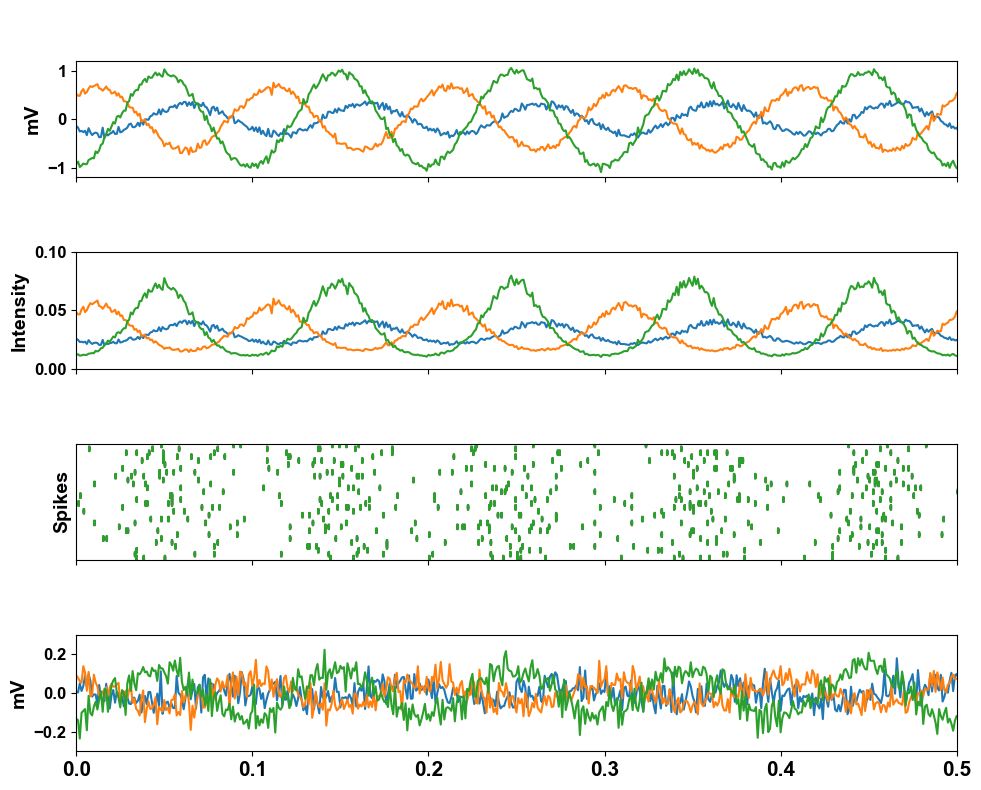

In [35]:

swap = False
ls = [1,4,9]
fig,ax = plt.subplots(4,1,figsize=(10,8), sharex=True)
start = 2
title_size = 16
label_size = 14
x = np.arange(0, sample_length) / 1000
# for i in range(start,start+3):
for i, l in enumerate(ls):
# i = 3
    ax[3].plot(x, xys[l,:])
    ax[3].set_ylim([-.3,.3])
    ax[3].margins(0)
    ax[3].set_ylabel('mV', size = label_size)
    
    ax[0].plot(x, xns[l,:])
    ax[0].set_ylim([-1.2,1.2])
    ax[0].margins(0)
    ax[0].set_ylabel('mV', size = label_size)
    
    ax[1].plot(x, lamb[l,5,:])
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)


ax[0].tick_params(axis='y', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[3].tick_params(axis='y', labelsize=12)
ax[3].tick_params(axis='x', labelsize=15)
ax[0].set_title('BLANK', color='white', fontsize=40)
ax[1].set_title('BLANK', color='white', fontsize=40)
ax[2].set_title('BLANK', color='white', fontsize=40)
ax[3].set_title('BLANK', color='white', fontsize=40)

ax[1].set_ylim(0,0.1)
color = 'tab:green'
spike_mat = spikes[ls[2],:,:]
draw_raster_single_mod(spike_mat, trange=[0,sample_length/1000], region='CPB', color_name=color, override_bg_color=None, ax=ax[2])
# ax[2].set_title(r'$n_t^{c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
ax[2].set_ylabel('Spikes', size = label_size)

# ax[3].set_xlabel('Time (sec)', size = label_size)
plt.xlim([0,0.5])
plt.tight_layout()
plt.savefig('synthetic_new.pdf')

In [ ]:
# sample_length = 2000 # sample length (was slen in notebook)
# seed = 8
# L = 40
# C = 30
# snu = 0.1
# mu = -4.0
# snu_init = 0.5
# num_em_iters_lfp = 20


In [16]:
# L = 25
# sample_length = 5000
# C = 20
# mu = -3.5
# save_path = f'saved/synthetic_data_new/simple_synthetic_{L}_{sample_length}_{C}_{mu}_0.1_8'

# data_load = pickle_open(save_path)

# pp_params = data_load['observed']['pp_params']
# lfp = data_load['observed']['lfp']
# spikes = data_load['observed']['spikes']

# xns = data_load['latent']['xns']
# xys = data_load['latent']['xys']
# zs = data_load['latent']['zs']

# xnfs = data_load['latent']['xnfs']
# xyfs = data_load['latent']['xyfs']
# Gamma = data_load['latent']['Gamma']

# true_coh = data_load['meta']['coh_true']
# coh1 = data_load['meta']['coh_direct_est']
# freqs = data_load['meta']['freqs']
# sample_length = data_load['meta']['sample_length']
# L = data_load['meta']['L']
# C = data_load['meta']['C']



model_save_path = f'saved/fitted_models_new/simple_synthetic_{L}_{sample_length}_{C}_{mu}_0.1_8'
model_fit = pickle_open(model_save_path)

In [17]:
def conv_zns(zns):
    L = zns.shape[0]
    J = zns.shape[1]
    znsc = np.zeros((L, int(J/2)), dtype=complex)

    for l in range(L):
        for j in range(int(J/2)):
            ri = j*2
            a = zns[l,ri]
            b = zns[l,ri+1]
            c = conv_real_to_complex(a,b)
            znsc[l,j] = c
    return znsc.squeeze()

In [19]:
z_ests_lfp = model_fit['lfp']['z_ests']
v_ests = model_fit['spikes']['v_ests']

In [21]:
from cohlib.utils import conv_real_to_complex
cnss = []
for l in range(L):
    cns = conv_zns(v_ests[l,:][None,:])
    cnss.append(cns)
z_ests_spikes = np.stack(cnss)
# plt.plot(freqs[1:], 1000*(cns*cns.conj()).real)
# plt.xlim([0,100])

In [22]:
ns_c = np.zeros_like(spikes)
for l in range(L):
    ns_c[l,:,:] = spikes[l,:,:] - (spikes[l,:,:].mean(1)[:,None])

In [25]:
from scipy.fft import rfft, irfft, rfftfreq
from cohlib.estimation import thr_coherence, estimate_coherence

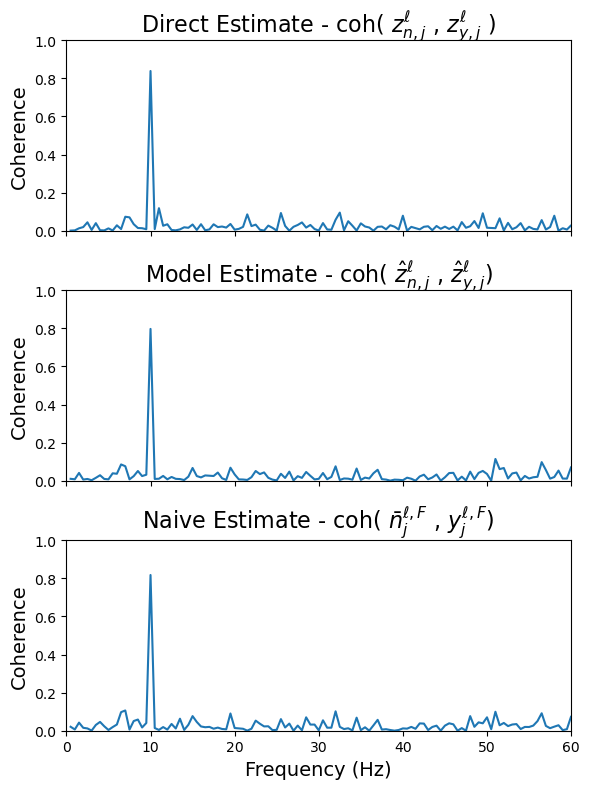

In [36]:
fig, ax = plt.subplots(3,1, figsize=(6,8), sharex=True)
tru_test = estimate_coherence(xnfs, xyfs)
title_size = 16
label_size = 14
# ax[0].plot(freqs[1:], tru_test)
ax[0].plot(freqs, tru_test)
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,1])
ax[0].set_title(r'Direct Estimate - coh( $z^{\ell}_{n,j}$ , $z^{\ell}_{y,j}$ )', size=title_size)
ax[0].set_ylabel('Coherence', size=label_size)

# mtd_test = estimate_coherence(z_ests, xyfs[:,1:])

# mtd_test = estimate_coherence(z_ests_track[3,:], z_ests_lfp)
mtd_test = estimate_coherence(z_ests_spikes, z_ests_lfp)
ax[1].plot(freqs, mtd_test)
ax[1].set_xlim([0,60])
ax[1].set_ylim([0,1])
ax[1].set_title(r'Model Estimate - coh( $\hat{z}^{\ell}_{n,j}$ , $\hat{z}^{\ell}_{y,j}$)', size=title_size)
ax[1].set_ylabel('Coherence', size=label_size)


# ns_c = (spikes - spikes.mean(2)[:,:,None])
ns_c = np.zeros_like(spikes)
for l in range(L):
    ns_c[l,:,:] = spikes[l,:,:] - (spikes[l,:,:].mean(1)[:,None])
# xys_c = xys - xys.mean(1)[:,None]

mns_c = ns_c.mean(1)
mnfs = rfft(mns_c, axis=1)

lfp_c = (lfp - lfp.mean(1)[:,None])
lfp_f = rfft(lfp_c, axis=1)

raw_test = estimate_coherence(mnfs[:,1:], lfp_f[:,1:])
ax[2].plot(freqs, raw_test)
ax[2].set_xlim([0,60])
ax[2].set_ylim([0,1])
ax[2].set_title(r'Naive Estimate - coh( $\bar{n}^{\ell,F}_{j}$ , $y^{\ell,F}_j$)', size=title_size)
ax[2].set_ylabel('Coherence', size=label_size)
ax[2].set_xlabel('Frequency (Hz)', size=label_size)

# new_test = estimate_coherence(z_ests, z_ests_lfp)
# ax[3].plot(freqs[1:], new_test)
# plt.xlim([0,60])
# plt.ylim([0,1])
plt.tight_layout()
if swap:
    plt.savefig('swap_coh.png', dpi=300)
else:
    plt.savefig('no_swap_coh.png', dpi=300)

In [39]:
ind10 = np.where(freqs==10)[0]

Text(0, 0.5, 'Coherence')

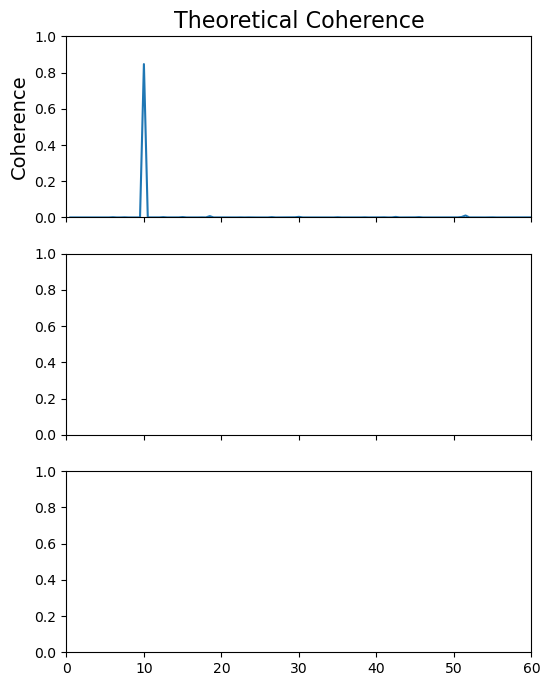

In [41]:
fig, ax = plt.subplots(3,1, figsize=(6,8), sharex=True)
tru_test = thr_coherence(Gamma)
title_size = 16
label_size = 14
# ax[0].plot(freqs[1:], tru_test)
ax[0].plot(freqs, tru_test)
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,1])
ax[0].set_title(r'Theoretical Coherence', size=title_size)
ax[0].set_ylabel('Coherence', size=label_size)